In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import iris.analysis.maths as imath
from iris.pandas import as_data_frame

from glob import glob
import seaborn as sns

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore') # Ignore all the iris warnings...

In [2]:
SECONDS_IN_YEAR = 60*60*24*365 #s
convert = lambda x: x * SECONDS_IN_YEAR * 1e-12 # kg -> Gt

data_path = "F:\\Local Data\\ClimateBench\\"

# Only future scenarios for now
inputs = glob(data_path + "inputs_s*.nc")

def get_weights(cube):
    # Iris is pretty fussy...
    cube_ = cube.copy()
    if cube_.coords('lat'):
        cube_.coord('lat').rename('latitude')
    if cube_.coords('lon'):
        cube_.coord('lon').rename('longitude')
    if not cube_.coord('latitude').has_bounds():
        cube_.coord('latitude').guess_bounds()
    if not cube_.coord('longitude').has_bounds():
        cube_.coord('longitude').guess_bounds()
    if cube_.coord('latitude').units == 'unknown':
        cube_.coord('latitude').units = 'degrees'
    if cube_.coord('longitude').units == 'unknown':
        cube_.coord('longitude').units = 'degrees'
    return iris.analysis.cartography.area_weights(cube_, normalize=False)


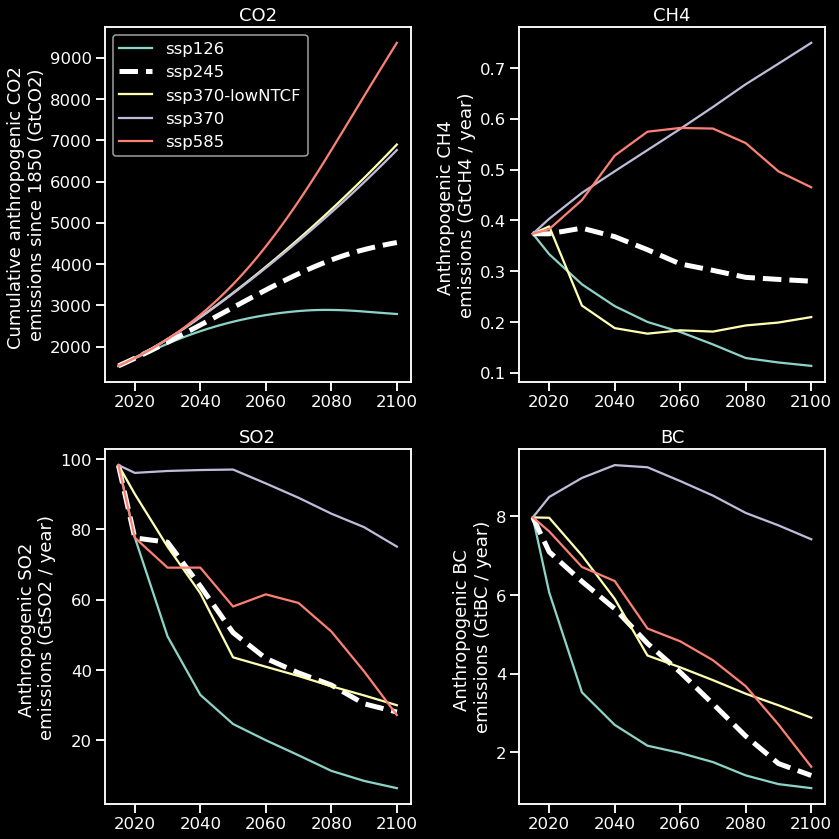

In [3]:
with sns.plotting_context("talk"):
#     sns.set(style="ticks", context="talk")
    plt.style.use("dark_background")

#     sns.set_style('dark')
    fig, axes = plt.subplots(2, 2, figsize=(12,12))

    for input in inputs:
        label=input.split('_')[1][:-3]
        X = iris.load(input)
        x = range(2015, 2101)
        
        kwargs = {}
        if label == "ssp245":
            kwargs['color'] = 'white'
            kwargs['ls'] = '--'
            kwargs['lw'] = '5'
        axes[0, 0].plot(x, X.extract_cube('CO2').data, label=label, **kwargs)
        axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
        axes[0, 1].plot(x, X.extract_cube('CH4').data, label=label, **kwargs)
        axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
        # FIXME: Not sure where this factor of 1000 comes from...! Maybe the CEDS data is really g/m-2/s?
        axes[1, 0].plot(x, convert(X.extract_cube('SO2').collapsed(['latitude', 'longitude'], iris.analysis.SUM, weights=get_weights(X.extract_cube('SO2'))).data*1000), label=label, **kwargs)
        axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (GtSO2 / year)")
        axes[1, 1].plot(x, convert(X.extract_cube('BC').collapsed(['latitude', 'longitude'], iris.analysis.SUM, weights=get_weights(X.extract_cube('SO2'))).data*1000), label=label, **kwargs)
        axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (GtBC / year)")

    axes[0, 0].set_title('CO2')
    axes[0, 1].set_title('CH4')
    axes[1, 0].set_title('SO2')
    axes[1, 1].set_title('BC')
    axes[0, 0].legend()
    plt.tight_layout()

In [4]:
from iris.cube import CubeList
# Get one combined historical + ssp585 timeseries for now
X = (iris.load(data_path + 'inputs_historical.nc') + iris.load(data_path + 'inputs_ssp585.nc')).concatenate()
# Just take the 1st ensemble member for this scenario
Y = CubeList([c[0] for c in iris.load(data_path + 'outputs_historical.nc') + iris.load(data_path + 'outputs_ssp585.nc')]).concatenate()


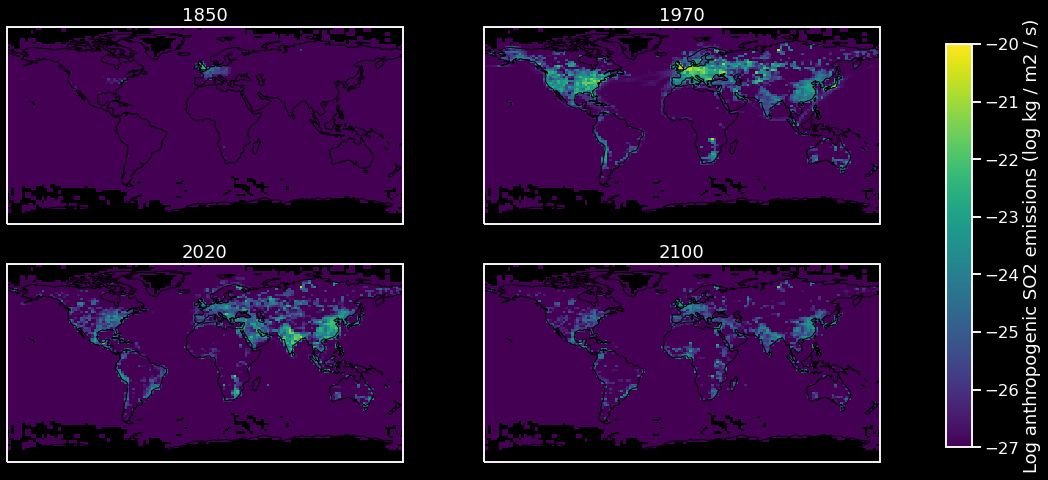

In [5]:
with sns.plotting_context("talk"):
#     sns.set(style="ticks", context="talk")
    plt.style.use("dark_background")

    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(18, 8))
    plt.subplot(221, projection=proj)
    iplt.pcolormesh(imath.log(X.extract_cube("SO2").extract(iris.Constraint(time=1850))), vmin=-27, vmax=-20)
    plt.gca().coastlines()
    plt.gca().set_title('1850')

    plt.subplot(222, projection=proj)
    iplt.pcolormesh(imath.log(X.extract_cube("SO2").extract(iris.Constraint(time=1970))), vmin=-27, vmax=-20)
    plt.gca().coastlines()
    plt.gca().set_title('1970')

    plt.subplot(223, projection=proj)
    iplt.pcolormesh(imath.log(X.extract_cube("SO2").extract(iris.Constraint(time=2020))), vmin=-27, vmax=-20)
    plt.gca().coastlines()
    plt.gca().set_title('2020')

    plt.subplot(224, projection=proj)
    m=iplt.pcolormesh(imath.log(X.extract_cube("SO2").extract(iris.Constraint(time=2100))), vmin=-27, vmax=-20)
    plt.gca().coastlines()
    plt.gca().set_title('2100')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(m, cax=cbar_ax)
    cbar.set_label('Log anthropogenic SO2 emissions (log kg / m2 / s)')

In [6]:
from ipywidgets import IntSlider, interact

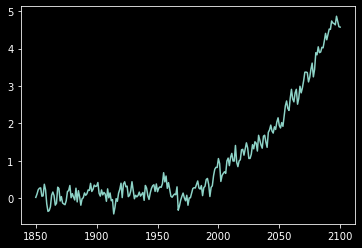

In [7]:
iplt.plot(Y.extract_cube("tas").collapsed(['lat','lon'], iris.analysis.MEAN))

In [8]:
def func(i):
    ax = plt.axes(projection=ccrs.PlateCarree())
    iplt.pcolormesh(Y.extract_cube("tas").extract(iris.Constraint(time=i)), vmin=0, vmax=10, cmap='Reds')
    ax.coastlines()
    plt.colorbar()
    plt.show()
    
interact(func,i=IntSlider(min=1850, max=2100, step=1, continuous_update=False));

interactive(children=(IntSlider(value=1850, continuous_update=False, description='i', max=2100, min=1850), Out…

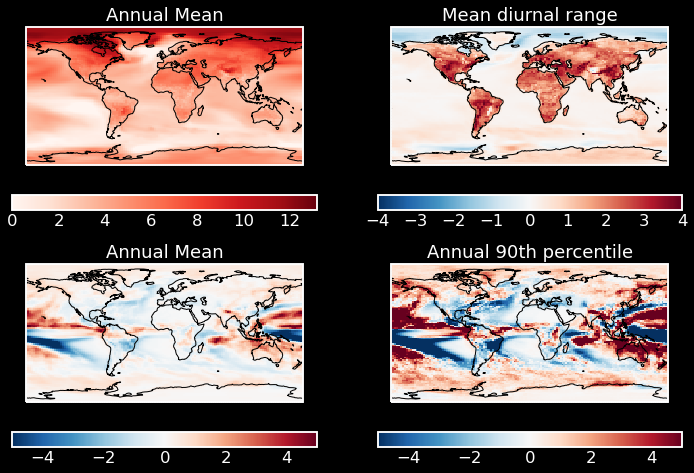

In [9]:
with sns.plotting_context("talk"):
#     sns.set(style="ticks", context="talk")
    plt.style.use("dark_background")

    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(12, 8))
    plt.subplot(221, projection=proj)
    qplt.pcolormesh(Y.extract_cube("tas").extract(iris.Constraint(time=2100)), vmin=0, cmap='Reds')
    plt.gca().coastlines()
    plt.gca().set_title('Annual Mean')

    plt.subplot(222, projection=proj)
    qplt.pcolormesh(Y.extract_cube("diurnal_temperature_range").extract(iris.Constraint(time=2100)), vmin=-4, vmax=4, cmap='RdBu_r' )
    plt.gca().coastlines()
    plt.gca().set_title('Mean diurnal range')

    plt.subplot(223, projection=proj)
    #  Convert precip to mm/day
    qplt.pcolormesh(Y.extract_cube("pr").extract(iris.Constraint(time=2100))*86400 , vmin=-5, vmax=5, cmap='RdBu_r')
    plt.gca().coastlines()
    plt.gca().set_title('Annual Mean')

    plt.subplot(224, projection=proj)
    qplt.pcolormesh(Y.extract_cube("pr90").extract(iris.Constraint(time=2100))*86400, vmin=-5, vmax=5, cmap='RdBu_r')
    plt.gca().coastlines()
    plt.gca().set_title('Annual 90th percentile')

